# Learn VAE on Game datasets


## Standard-Imports


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install keras


You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.



## Loading Datasets

- Mario datasets will be used. Use the first 4 Worlds for training and the others for testing


In [7]:

game_name = "mario"
output = "v2"

downsampled = []
original = []
actions = []
rewards = []

import os
record_files = [filename for filename in os.listdir(f'./record/Mario')
                    if os.path.isfile(f"./record/{game_name}/{filename}") and filename.startswith(f"record_{game_name}")]
for file in record_files[0:12]:
    print("load file: ", file)
    data = np.load(f"./record/Mario/{file}", allow_pickle=True)
    if len(downsampled) == 0:
        downsampled = data["obs_downsampled"]
        original = data["obs_original"]
        actions = data["actions"]
        rewards = data["rewards"]
    else:
        downsampled = np.concatenate((downsampled, data["obs_downsampled"]))
        original = np.concatenate((original, data["obs_original"]))
        actions = np.concatenate((actions, data["actions"]))
        rewards = np.concatenate((rewards, data["rewards"]))

obs_train_downsampled = downsampled / 255.
obs_train = original / 255.
actions_train = actions
rewards_train = rewards

print("loaded obs_train_downsampled: ", downsampled.shape)
print("loaded obs_train: ", original.shape)
print("loaded actions_train: ", actions.shape)
print("loaded rewards_train: ", rewards.shape)


downsampled = []
original = []
actions = []
rewards = []

for file in record_files[12:24]:
    print("load file: ", file)
    data = np.load(f"./record/Mario/{file}", allow_pickle=True)
    if len(downsampled) == 0:
        downsampled = data["obs_downsampled"]
        original = data["obs_original"]
        actions = data["actions"]
        rewards = data["rewards"]
    else:
        downsampled = np.concatenate((downsampled, data["obs_downsampled"]))
        original = np.concatenate((original, data["obs_original"]))
        actions = np.concatenate((actions, data["actions"]))
        rewards = np.concatenate((rewards, data["rewards"]))

obs_test_downsampled = downsampled / 255.
obs_test = original / 255.
actions_test = actions
rewards_test = rewards

print("loaded obs_test_downsampled: ", downsampled.shape)
print("loaded obs_test: ", original.shape)
print("loaded actions_test: ", actions.shape)
print("loaded rewards_test: ", rewards.shape)


load file:  record_mario_1_1_v2_0.npz
load file:  record_mario_1_1_v2_1.npz
load file:  record_mario_1_1_v2_2.npz
load file:  record_mario_1_2_v2_0.npz
load file:  record_mario_1_2_v2_1.npz
load file:  record_mario_1_2_v2_2.npz
load file:  record_mario_1_3_v2_0.npz
load file:  record_mario_1_3_v2_1.npz
load file:  record_mario_1_3_v2_2.npz
load file:  record_mario_1_4_v2_0.npz
load file:  record_mario_1_4_v2_1.npz
load file:  record_mario_1_4_v2_2.npz
loaded obs_train_downsampled:  (11190, 64, 64, 3)
loaded obs_train:  (11190, 240, 256, 3)
loaded actions_train:  (11190,)
loaded rewards_train:  (11190,)
load file:  record_mario_2_1_v2_0.npz
load file:  record_mario_2_1_v2_1.npz
load file:  record_mario_2_1_v2_2.npz
load file:  record_mario_2_2_v2_0.npz
load file:  record_mario_2_2_v2_1.npz
load file:  record_mario_2_2_v2_2.npz
load file:  record_mario_2_3_v2_0.npz
load file:  record_mario_2_3_v2_1.npz
load file:  record_mario_2_3_v2_2.npz
load file:  record_mario_2_4_v2_0.npz
load file:

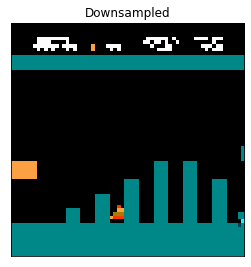

(11190, 240, 256, 3)


In [30]:
import random
index = random.choice(range(len(obs_train)))
plt.imshow(obs_train_downsampled[index,:,:,:])
plt.title("Downsampled")
plt.tight_layout()
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.show()

print(obs_train.shape)


In [23]:
## Simple Auto-Encoder

def pad_along_axis(array: np.ndarray, target_length, axis=0):

    npad = [(0, 0) for _ in range(len(array.shape))]

    for axes in axis:
        
        pad_size = (target_length - array.shape[axes])
        if pad_size % 2 == 0:
            npad[axes] = (pad_size//2, pad_size//2)
        else:
            npad[axes] = (pad_size//2, pad_size//2+1)

    b = np.pad(array, pad_width=npad, mode='constant', constant_values=0)

    return b

In [31]:

import numpy as np

from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(64, 64, 3))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = UpSampling2D((2, 2))(encoded)
x = Conv2D(16, (3, 3), activation='sigmoid', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [35]:
autoencoder.fit(obs_train_downsampled, obs_train_downsampled,
                epochs=10,
                batch_size=1024,
                shuffle=True,
                validation_data=(obs_test_downsampled, obs_test_downsampled))


Train on 11190 samples, validate on 5596 samples
Epoch 1/10
11190/11190 [==============================] - 91s 8ms/step - loss: 0.5944 - val_loss: 0.5514
Epoch 2/10
11190/11190 [==============================] - 88s 8ms/step - loss: 0.4806 - val_loss: 0.5076
Epoch 3/10
11190/11190 [==============================] - 87s 8ms/step - loss: 0.4347 - val_loss: 0.5017
Epoch 4/10
11190/11190 [==============================] - 90s 8ms/step - loss: 0.4192 - val_loss: 0.4794
Epoch 5/10
11190/11190 [==============================] - 86s 8ms/step - loss: 0.4079 - val_loss: 0.4865
Epoch 6/10
11190/11190 [==============================] - 86s 8ms/step - loss: 0.4011 - val_loss: 0.4672
Epoch 7/10
11190/11190 [==============================] - 87s 8ms/step - loss: 0.3968 - val_loss: 0.4826
Epoch 8/10
11190/11190 [==============================] - 88s 8ms/step - loss: 0.3926 - val_loss: 0.4605
Epoch 9/10
11190/11190 [==============================] - 89s 8ms/step - loss: 0.3902 - val_loss: 0.4813
Epoch 

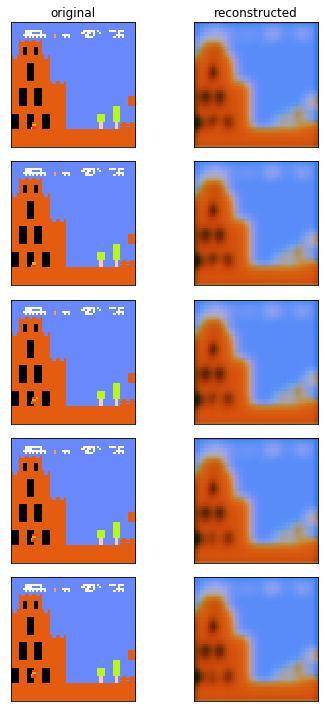

In [36]:

decoded_imgs = autoencoder.predict(obs_test_downsampled)

n = 5
_, ax = plt.subplots(n,2, figsize=(6,10))

for i in range(n):
    # display original
    ax[i,0].imshow(obs_test_downsampled[i,:,:,:].reshape(64, 64, 3))
    ax[i,0].get_xaxis().set_visible(False)
    ax[i,0].get_yaxis().set_visible(False)
    
    # display reconstruction
    ax[i,1].imshow(decoded_imgs[i,:,:,:].reshape(64, 64, 3))
    ax[i,1].get_xaxis().set_visible(False)
    ax[i,1].get_yaxis().set_visible(False)
    
    if i == 0:
        ax[i,0].set_title("original")
        ax[i,1].set_title("reconstructed")
        
plt.tight_layout()
plt.show()
    

In [ ]:
print(actions[0:4])




## Simple Convolutional Variational Auto-Encoder


In [37]:

import numpy as np
import json
import tensorflow as tf
import os


def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()


class ConvVAE(object):
  def __init__(self, z_size=32, batch_size=1, learning_rate=0.0001, kl_tolerance=0.5, is_training=False,
               reuse=False, gpu_mode=False):
    self.z_size = z_size
    self.batch_size = batch_size
    self.learning_rate = learning_rate
    self.is_training = is_training
    self.kl_tolerance = kl_tolerance
    self.reuse = reuse

    with tf.variable_scope('conv_vae', reuse=self.reuse):
      if not gpu_mode:
        with tf.device('/cpu:0'):
          tf.logging.info('Model using cpu.')
          self._build_graph()
      else:
        tf.logging.info('Model using gpu.')
        self._build_graph()
    self._init_session()

  def _build_graph(self):
    self.g = tf.Graph()
    with self.g.as_default():

      self.x = tf.placeholder(tf.float32, shape=[None, 64, 64, 3])

      # Encoder
      h = tf.layers.conv2d(self.x, 32, 4, strides=2, activation=tf.nn.relu, name="enc_conv1")
      h = tf.layers.conv2d(h, 64, 4, strides=2, activation=tf.nn.relu, name="enc_conv2")
      h = tf.layers.conv2d(h, 128, 4, strides=2, activation=tf.nn.relu, name="enc_conv3")
      h = tf.layers.conv2d(h, 256, 4, strides=2, activation=tf.nn.relu, name="enc_conv4")
      h = tf.reshape(h, [-1, 2*2*256])

      # VAE
      self.mu = tf.layers.dense(h, self.z_size, name="enc_fc_mu")
      self.logvar = tf.layers.dense(h, self.z_size, name="enc_fc_log_var")
      self.sigma = tf.exp(self.logvar / 2.0)
      self.epsilon = tf.random_normal([self.batch_size, self.z_size])
      self.z = self.mu + self.sigma * self.epsilon

      # Decoder
      h = tf.layers.dense(self.z, 4*256, name="dec_fc")
      h = tf.reshape(h, [-1, 1, 1, 4*256])
      h = tf.layers.conv2d_transpose(h, 128, 5, strides=2, activation=tf.nn.relu, name="dec_deconv1")
      h = tf.layers.conv2d_transpose(h, 64, 5, strides=2, activation=tf.nn.relu, name="dec_deconv2")
      h = tf.layers.conv2d_transpose(h, 32, 6, strides=2, activation=tf.nn.relu, name="dec_deconv3")
      self.y = tf.layers.conv2d_transpose(h, 3, 6, strides=2, activation=tf.nn.sigmoid, name="dec_deconv4")
      
      # train ops
      if self.is_training:
        self.global_step = tf.Variable(0, name='global_step', trainable=False)

        eps = 1e-6 # avoid taking log of zero
        
        # reconstruction loss
        self.r_loss = tf.reduce_sum(
          tf.square(self.x - self.y),
          reduction_indices = [1,2,3]
        )
        self.r_loss = tf.reduce_mean(self.r_loss)

        # augmented kl loss per dim
        self.kl_loss = - 0.5 * tf.reduce_sum(
          (1 + self.logvar - tf.square(self.mu) - tf.exp(self.logvar)),
          reduction_indices = 1
        )
        self.kl_loss = tf.maximum(self.kl_loss, self.kl_tolerance * self.z_size)
        self.kl_loss = tf.reduce_mean(self.kl_loss)
        
        self.loss = self.r_loss + self.kl_loss
        
        # training
        self.lr = tf.Variable(self.learning_rate, trainable=False)
        self.optimizer = tf.train.AdamOptimizer(self.lr)
        grads = self.optimizer.compute_gradients(self.loss) # can potentially clip gradients here.

        self.train_op = self.optimizer.apply_gradients(
          grads, global_step=self.global_step, name='train_step')

      # initialize vars
      self.init = tf.global_variables_initializer()
      
      t_vars = tf.trainable_variables()
      self.assign_ops = {}
      for var in t_vars:
        #if var.name.startswith('conv_vae'):
        pshape = var.get_shape()
        pl = tf.placeholder(tf.float32, pshape, var.name[:-2]+'_placeholder')
        assign_op = var.assign(pl)
        self.assign_ops[var] = (assign_op, pl)


  def _init_session(self):
    """Launch TensorFlow session and initialize variables"""
    self.sess = tf.Session(graph=self.g)
    self.sess.run(self.init)
      
  def close_sess(self):
    """ Close TensorFlow session """
    self.sess.close()
      
  def encode(self, x):
    return self.sess.run(self.z, feed_dict={self.x: x})
  
  def encode_mu_logvar(self, x):
    (mu, logvar) = self.sess.run([self.mu, self.logvar], feed_dict={self.x: x})
    return mu, logvar
  
  def decode(self, z):
    return self.sess.run(self.y, feed_dict={self.z: z})
  
  def get_model_params(self):
    # get trainable params.
    model_names = []
    model_params = []
    model_shapes = []
    with self.g.as_default():
      t_vars = tf.trainable_variables()
      for var in t_vars:
        #if var.name.startswith('conv_vae'):
        param_name = var.name
        p = self.sess.run(var)
        model_names.append(param_name)
        params = np.round(p*10000).astype(np.int).tolist()
        model_params.append(params)
        model_shapes.append(p.shape)
    return model_params, model_shapes, model_names
  
  def get_random_model_params(self, stdev=0.5):
    # get random params.
    _, mshape, _ = self.get_model_params()
    rparam = []
    for s in mshape:
      #rparam.append(np.random.randn(*s)*stdev)
      rparam.append(np.random.standard_cauchy(s)*stdev) # spice things up
    return rparam
  
  def set_model_params(self, params):
    with self.g.as_default():
      t_vars = tf.trainable_variables()
      idx = 0
      for var in t_vars:
        #if var.name.startswith('conv_vae'):
        pshape = tuple(var.get_shape().as_list())
        p = np.array(params[idx])
        assert pshape == p.shape, "inconsistent shape"
        assign_op, pl = self.assign_ops[var]
        self.sess.run(assign_op, feed_dict={pl.name: p/10000.})
        idx += 1
              
  def load_json(self, jsonfile='vae.json'):
    with open(jsonfile, 'r') as f:
      params = json.load(f)
    self.set_model_params(params)
      
  def save_json(self, jsonfile='vae.json'):
    model_params, model_shapes, model_names = self.get_model_params()
    qparams = []
    for p in model_params:
      qparams.append(p)
    with open(jsonfile, 'wt') as outfile:
      json.dump(qparams, outfile, sort_keys=True, indent=0, separators=(',', ': '))
          
  def set_random_params(self, stdev=0.5):
    rparam = self.get_random_model_params(stdev)
    self.set_model_params(rparam)
      
  def save_model(self, model_save_path):
    sess = self.sess
    with self.g.as_default():
      saver = tf.train.Saver(tf.global_variables())
    checkpoint_path = os.path.join(model_save_path, 'vae')
    tf.logging.info('saving model %s.', checkpoint_path)
    saver.save(sess, checkpoint_path, 0) # just keep one
      
  def load_checkpoint(self, checkpoint_path):
    sess = self.sess
    with self.g.as_default():
      saver = tf.train.Saver(tf.global_variables())
    ckpt = tf.train.get_checkpoint_state(checkpoint_path)
    print('loading model', ckpt.model_checkpoint_path)
    tf.logging.info('Loading model %s.', ckpt.model_checkpoint_path)
    saver.restore(sess, ckpt.model_checkpoint_path)



In [38]:

# Hyperparameters for ConvVAE
z_size=32
batch_size=64
learning_rate=0.0001
kl_tolerance=0.5

vae = ConvVAE(z_size=z_size,
              batch_size=batch_size,
              learning_rate=learning_rate,
              kl_tolerance=kl_tolerance,
              is_training=True,
              reuse=False,
              gpu_mode=True)

reset_graph()
total_epochs = 0


INFO:tensorflow:Model using gpu.
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use keras.layers.conv2d_transpose instead.


In [46]:

NUM_EPOCH = 10
dataset = obs_train_downsampled

total_length = len(dataset)

num_batches = int(np.floor(total_length/batch_size))
print(f"num_batches per epoch = {num_batches}")

# train loop:

print("train", "step", "loss", "recon_loss", "kl_loss")
for epoch in range(NUM_EPOCH):
  print(f"epoch: {epoch}")
  np.random.shuffle(dataset)
  for idx in range(num_batches):
    batch = dataset[idx*batch_size:(idx+1)*batch_size]

    obs = batch.astype(np.float)
    #obs = pad_along_axis(obs, 256, axis=[1,2])

    feed = {vae.x: obs,}

    (train_loss, r_loss, kl_loss, train_step, _) = vae.sess.run([
      vae.loss, vae.r_loss, vae.kl_loss, vae.global_step, vae.train_op
    ], feed)
  
    if ((train_step+1) % 10 == 0):
      print("step", (train_step+1), train_loss, r_loss, kl_loss)
  
  total_epochs += 1  
  vae.save_json(f"tf_vae/vae_epochs_{game_name}_{total_epochs}.json")
          

num_batches per epoch = 174
train step loss recon_loss kl_loss
epoch: 0
step 1750 105.79782 85.83624 19.961576
step 1760 122.659424 103.15192 19.507504
step 1770 90.70444 71.853546 18.850891
step 1780 106.408905 86.49466 19.914244
step 1790 111.14285 92.48541 18.65744
step 1800 73.926575 55.88096 18.045614
step 1810 99.99699 80.35139 19.6456
step 1820 88.85913 70.342636 18.51649
step 1830 92.08974 74.10234 17.987392
step 1840 90.01033 71.125244 18.885086
step 1850 94.14078 75.79344 18.347332
step 1860 112.19803 90.76068 21.437344
step 1870 101.155365 82.23795 18.917412
step 1880 111.61429 91.72873 19.885561
step 1890 102.90055 84.73514 18.165413
step 1900 82.5 64.90953 17.59047
step 1910 68.714615 51.02173 17.69289
epoch: 1
step 1920 110.41641 91.53465 18.881763
step 1930 91.645874 73.15358 18.49229
step 1940 87.05447 67.93358 19.120886
step 1950 113.21908 93.39747 19.82161
step 1960 105.942276 85.02783 20.914448
step 1970 112.59309 92.39418 20.198904
step 1980 68.91058 50.65912 18.251

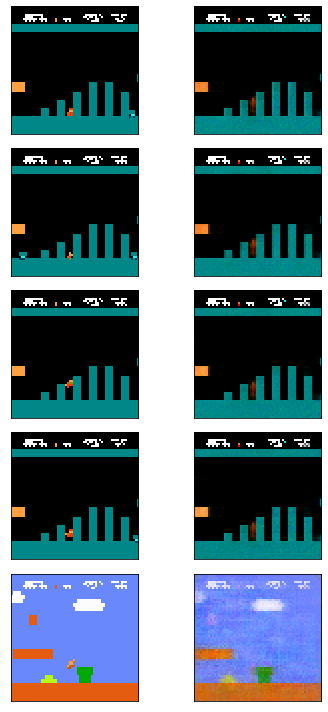

In [48]:
idx = 0
obs = obs_train_downsampled[idx*batch_size:(idx+1)*batch_size,:,:,:]
pred = vae.decode(vae.encode(obs))

n = 5
_, ax = plt.subplots(n,2, figsize=(6,10))

for i, ind in enumerate(random.sample(range(batch_size), n)):
    # display original
    ax[i,0].imshow(obs[ind,:,:,:].reshape(64, 64, 3))
    ax[i,0].get_xaxis().set_visible(False)
    ax[i,0].get_yaxis().set_visible(False)
    
    # display reconstruction
    ax[i,1].imshow(pred[ind,:,:,:].reshape(64, 64, 3))
    ax[i,1].get_xaxis().set_visible(False)
    ax[i,1].get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()
    
    